# Interactive Neuroscope

*This is an interactive accompaniment to [neuroscope.io](https://neuroscope.io) and to the [studying learned language features post](https://www.alignmentforum.org/posts/Qup9gorqpd9qKAEav/200-cop-in-mi-studying-learned-features-in-language-models) in [200 Concrete Open Problems in Mechanistic Interpretability](https://neelnanda.io/concrete-open-problems)*

There's a surprisingly rich ecosystem of easy ways to create interactive graphics, especially for ML systems. If you're trying to do mechanistic interpretability, the ability to do web dev and to both visualize data and interact with it seems high value! 

This is a demo of how you can combine HookedTransformer and [Gradio](https://gradio.app/) to create an interactive Neuroscope - a visualization of a neuron's activations on text that will dynamically update as you edit the text. I don't particularly claim that this code is any *good*, but the goal is to illustrate what quickly hacking together a custom visualisation (while knowing fuck all about web dev, like me) can look like! (And as such, I try to explain the basic web dev concepts I use)

Note that you'll need to run the code yourself to get the interactive interface, so the cell at the bottom will be blank at first!

To emphasise - the point of this notebook is to be a rough proof of concept that just about works, *not* to be the well executed ideal of interactively studying neurons! You are highly encouraged to write your own (and ideally, to [make a pull request](https://github.com/neelnanda-io/TransformerLens/pulls) with improvements!)

## Setup

In [1]:
import os

try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Jupyter notebook - intended for development only!


C:\Users\marti\AppData\Local\Temp\ipykernel_17816\1796901329.py:16: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
C:\Users\marti\AppData\Local\Temp\ipykernel_17816\1796901329.py:17: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:
import os

if IN_COLAB:
    os.system("pip install git+https://github.com/neelnanda-io/TransformerLens.git")
    os.system("pip install gradio")

In [3]:
import gradio as gr
from transformer_lens import HookedTransformer
from transformer_lens.utils import to_numpy
from IPython.display import HTML

## Extracting Model Activations

We first write some code using HookedTransformer's cache to extract the neuron activations on a given layer and neuron, for a given text

In [4]:
model_name = "gpt2-small"
model = HookedTransformer.from_pretrained(model_name)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [52]:
import matplotlib.pyplot as plt
###

In [ ]:
DEVELOPMENT_MODE = False


In [61]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

# colab ok for jup

Using renderer: colab


In [53]:
import plotly.express as px


def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [55]:
def get_neuron_acts2(text, layer, neuron_index, neuron_index2):
    # Hacky way to get out state from a single hook - we have a single element list and edit that list within the hook.
    cache = {}
    
    ###my=0
    mym=[0]
    
    def caching_hook(act, hook):
        #cache["activation"] = act[0, :, neuron_index]
        cache["activation"] = act[0, :,  neuron_index: neuron_index2]
        mym[0] += 1


    model.run_with_hooks(
        text, fwd_hooks=[(f"blocks.{layer}.mlp.hook_post", caching_hook)]
    )
    
    #print(mym)
    #print(cache)
    #  {'activation': tensor([-0.0864, -0.1407, -0.1040, -0.
    
    return to_numpy(cache["activation"])

In [64]:
default_layer = 9
default_neuron_index = 652
default_text = "The following is a list of powers of 10: 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000"
default_text = "The following is a list of powers of 10: 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000000000000000000000000000000000000000"

print(model.to_str_tokens(default_text))
#print(
z=get_neuron_acts2(default_text, default_layer, default_neuron_index-200, default_neuron_index+200)
#)
#plt.plot(y)
#z

['<|endoftext|>', 'The', ' following', ' is', ' a', ' list', ' of', ' powers', ' of', ' 10', ':', ' 1', ',', ' 10', ',', ' 100', ',', ' 1000', ',', ' 10000', ',', ' 100', '000', ',', ' 100', '0000', ',', ' 100', '00000', ',', ' 100', '0000000000000000', '0000000000000000', '00000000', '00']


In [65]:
renderer=None
#px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)
px.imshow(
    z,
    #utils.to_numpy(tensor),
    color_continuous_midpoint=0.0, color_continuous_scale="RdBu",
    #labels={"x":xaxis, "y":yaxis}, **kwargs
).show(renderer)


Using renderer: colab


['<|endoftext|>', 'The', ' following', ' is', ' a', ' list', ' of', ' powers', ' of', ' 10', ':', ' 1', ',', ' 10', ',', ' 100', ',', ' 1000', ',', ' 10000', ',', ' 100', '000', ',', ' 100', '0000', ',', ' 100', '00000', ',', ' 100', '0000000000000000', '0000000000000000', '00000000', '00']


array([[ 0.06755365, -0.13233298, -0.03288722, ..., -0.04708958,
        -0.13092263,  0.01736375],
       [-0.02900731, -0.018326  , -0.04746269, ..., -0.12812833,
        -0.01375743, -0.13765523],
       [-0.06975956, -0.02031899, -0.10567567, ..., -0.03542395,
        -0.0111977 , -0.1073361 ],
       ...,
       [-0.16277203, -0.16405582, -0.13229673, ..., -0.08852355,
        -0.08102585, -0.16106121],
       [-0.13683423, -0.15546472, -0.14353141, ..., -0.02958243,
        -0.09077895, -0.15006311],
       [-0.16982993, -0.163437  , -0.16772014, ..., -0.01693174,
        -0.16755915, -0.16168776]], dtype=float32)

In [33]:
imshow(z)

NameError: name 'imshow' is not defined

In [29]:
def get_neuron_acts(text, layer, neuron_index):
    # Hacky way to get out state from a single hook - we have a single element list and edit that list within the hook.
    cache = {}
    
    ###my=0
    mym=[0]
    
    def caching_hook(act, hook):
        cache["activation"] = act[0, :, neuron_index]
        mym[0] += 1


    model.run_with_hooks(
        text, fwd_hooks=[(f"blocks.{layer}.mlp.hook_post", caching_hook)]
    )
    
    #print(mym)
    #print(cache)
    #  {'activation': tensor([-0.0864, -0.1407, -0.1040, -0.
    
    return to_numpy(cache["activation"])

['<|endoftext|>', 'The', ' following', ' is', ' a', ' list', ' of', ' powers', ' of', ' 10', ':', ' 1', ',', ' 10', ',', ' 100', ',', ' 1000', ',', ' 10000', ',', ' 100', '000', ',', ' 100', '0000', ',', ' 100', '00000', ',', ' 100', '0000000000000000', '0000000000000000', '00000000', '00']


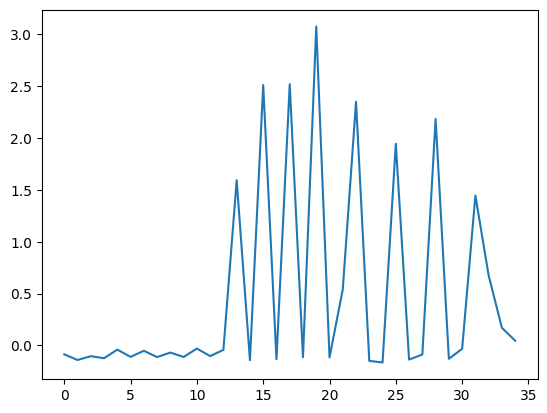

In [30]:
default_layer = 9
default_neuron_index = 652
default_text = "The following is a list of powers of 10: 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000"
default_text = "The following is a list of powers of 10: 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000000000000000000000000000000000000000"

print(model.to_str_tokens(default_text))
#print(
y=get_neuron_acts(default_text, default_layer, default_neuron_index)
#)
plt.plot(y)

## Visualizing Model Activations

We now write some code to visualize the neuron activations on some text - we're going to hack something together which just does some string processing to make an HTML string, with each token element colored according to the intensity neuron activation. We normalize the neuron activations so they all lie in [0, 1]. You can do much better, but this is a useful proof of concept of what "just hack stuff together" can look like!

I'll be keeping neuron 562 in layer 9 as a running example, as it seems to activate strongly on powers of 10.

Note that this visualization is very sensitive to `max_val` and `min_val`! You can tune those to whatever seems reasonable for the distribution of neuron activations you care about - I generally default to `min_val=0` and `max_val` as the max activation across the dataset.

In [25]:
# This is some CSS (tells us what style )to give each token a thin gray border, to make it easy to see token separation
style_string = """<style> 
    span.token {
        border: 1px solid rgb(123, 123, 123)
        } 
    </style>"""


def calculate_color(val, max_val, min_val):
    # Hacky code that takes in a value val in range [min_val, max_val], normalizes it to [0, 1] and returns a color which interpolates between slightly off-white and red (0 = white, 1 = red)
    # We return a string of the form "rgb(240, 240, 240)" which is a color CSS knows
    normalized_val = (val - min_val) / max_val
    return f"rgb(240, {240*(1-normalized_val)}, {240*(1-normalized_val)})"


def basic_neuron_vis(text, layer, neuron_index, max_val=None, min_val=None):
    """
    text: The text to visualize
    layer: The layer index
    neuron_index: The neuron index
    max_val: The top end of our activation range, defaults to the maximum activation
    min_val: The top end of our activation range, defaults to the minimum activation

    Returns a string of HTML that displays the text with each token colored according to its activation

    Note: It's useful to be able to input a fixed max_val and min_val, because otherwise the colors will change as you edit the text, which is annoying.
    """
    if layer is None:
        return "Please select a Layer"
    if neuron_index is None:
        return "Please select a Neuron"
    acts = get_neuron_acts(text, layer, neuron_index)
    act_max = acts.max()
    act_min = acts.min()
    # Defaults to the max and min of the activations
    if max_val is None:
        max_val = act_max
    if min_val is None:
        min_val = act_min
    # We want to make a list of HTML strings to concatenate into our final HTML string
    # We first add the style to make each token element have a nice border
    htmls = [style_string]
    # We then add some text to tell us what layer and neuron we're looking at - we're just dealing with strings and can use f-strings as normal
    # h4 means "small heading"
    htmls.append(f"<h4>Layer: <b>{layer}</b>. Neuron Index: <b>{neuron_index}</b></h4>")
    # We then add a line telling us the limits of our range
    htmls.append(
        f"<h4>Max Range: <b>{max_val:.4f}</b>. Min Range: <b>{min_val:.4f}</b></h4>"
    )
    # If we added a custom range, print a line telling us the range of our activations too.
    if act_max != max_val or act_min != min_val:
        htmls.append(
            f"<h4>Custom Range Set. Max Act: <b>{act_max:.4f}</b>. Min Act: <b>{act_min:.4f}</b></h4>"
        )
    # Convert the text to a list of tokens
    str_tokens = model.to_str_tokens(text)
    for tok, act in zip(str_tokens, acts):
        # A span is an HTML element that lets us style a part of a string (and remains on the same line by default)
        # We set the background color of the span to be the color we calculated from the activation
        # We set the contents of the span to be the token
        htmls.append(
            f"<span class='token' style='background-color:{calculate_color(act, max_val, min_val)}' >{tok}</span>"
        )

    return "".join(htmls)

In [26]:
# The function outputs a string of HTML
default_max_val = 4.0
default_min_val = 0.0
default_html_string = basic_neuron_vis(
    default_text,
    default_layer,
    default_neuron_index,
    max_val=default_max_val,
    min_val=default_min_val,
)

# IPython lets us display HTML
print("Displayed HTML")
display(HTML(default_html_string))

# We can also print the string directly
print("HTML String - it's just raw HTML code!")
print(default_html_string)

[1]
{'activation': tensor([-0.0864, -0.1407, -0.1040, -0.1239, -0.0406, -0.1106, -0.0519, -0.1128,
        -0.0691, -0.1119, -0.0306, -0.1034, -0.0432,  1.5936, -0.1421,  2.5117,
        -0.1332,  2.5197, -0.1136,  3.0765, -0.1164,  0.5394,  2.3500, -0.1495,
        -0.1648,  1.9449, -0.1369, -0.0880,  2.1849, -0.1293, -0.0331,  1.4460,
         0.6743,  0.1695,  0.0451], grad_fn=<SelectBackward0>)}
Displayed HTML


HTML String - it's just raw HTML code!
<style> 
    span.token {
        border: 1px solid rgb(123, 123, 123)
        } 
    </style><h4>Layer: <b>9</b>. Neuron Index: <b>652</b></h4><h4>Max Range: <b>4.0000</b>. Min Range: <b>0.0000</b></h4><h4>Custom Range Set. Max Act: <b>3.0765</b>. Min Act: <b>-0.1648</b></h4><span class='token' style='background-color:rgb(240, 245.18610075116158, 245.18610075116158)' ><|endoftext|></span><span class='token' style='background-color:rgb(240, 248.44318717718124, 248.44318717718124)' >The</span><span class='token' style='background-color:rgb(240, 246.23889058828354, 246.23889058828354)' > following</span><span class='token' style='background-color:rgb(240, 247.43444189429283, 247.43444189429283)' > is</span><span class='token' style='background-color:rgb(240, 242.43539080023766, 242.43539080023766)' > a</span><span class='token' style='background-color:rgb(240, 246.63893222808838, 246.63893222808838)' > list</span><span class='token' style='backgroun

## Create Interactive UI

We now put all these together to create an interactive visualization in Gradio! 

The internal format is that there's a bunch of elements - Textboxes, Numbers, etc which the user can interact with and which return strings and numbers. And we can also define output elements that just display things - in this case, one which takes in an arbitrary HTML string. We call `input.change(update_function, inputs, output)` - this says "if that input element changes, run the update function on the value of each of the elements in `inputs` and set the value of `output` to the output of the function". As a bonus, this gives us live interactivity!

This is also more complex than a typical Gradio intro example - I wanted to use custom HTML to display the nice colours, which made things much messier! Normally you could just make `out` into another Textbox and pass it a string.

In [27]:
# The `with gr.Blocks() as demo:` syntax just creates a variable called demo containing all these components
with gr.Blocks() as demo:
    gr.HTML(value=f"Hacky Interactive Neuroscope for {model_name}")
    # The input elements
    with gr.Row():
        with gr.Column():
            text = gr.Textbox(label="Text", value=default_text)
            # Precision=0 makes it an int, otherwise it's a float
            # Value sets the initial default value
            layer = gr.Number(label="Layer", value=default_layer, precision=0)
            neuron_index = gr.Number(
                label="Neuron Index", value=default_neuron_index, precision=0
            )
            # If empty, these two map to None
            max_val = gr.Number(label="Max Value", value=default_max_val)
            min_val = gr.Number(label="Min Value", value=default_min_val)
            inputs = [text, layer, neuron_index, max_val, min_val]
        with gr.Column():
            # The output element
            out = gr.HTML(label="Neuron Acts", value=default_html_string)
    for inp in inputs:
        inp.change(basic_neuron_vis, inputs, out)

We can now launch our demo element, and we're done! The setting share=True even gives you a public link to the demo (though it just redirects to the backend run by this notebook, and will go away once you turn the notebook off!) Sharing makes it much slower, and can be turned off if you aren't in a colab.

**Exercise:** Explore where this neuron does and does not activate. Is it just powers of ten? Just comma separated numbers? Numbers in any particular sequence?

In [28]:
#demo.launch(share=True, height=1000)
demo.launch(share=False , height=1000)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


[1]
{'activation': tensor([-0.0864, -0.1407, -0.1040, -0.1239, -0.0406, -0.1106, -0.0519, -0.1128,
        -0.0691, -0.1119, -0.0306, -0.1034, -0.0432,  1.5936, -0.1421,  2.5117,
        -0.1332,  2.5197, -0.1136,  3.0765, -0.1164,  0.5394,  2.3500, -0.1495,
        -0.1648,  1.9449, -0.1369, -0.0880,  2.1849, -0.1293, -0.0331,  1.4460,
         0.6743,  0.1822, -0.1069], grad_fn=<SelectBackward0>)}
[1]
{'activation': tensor([-0.0864, -0.1407, -0.1040, -0.1239, -0.0406, -0.1106, -0.0519, -0.1128,
        -0.0691, -0.1119, -0.0306, -0.1034, -0.0432,  1.5936, -0.1421,  2.5117,
        -0.1332,  2.5197, -0.1136,  3.0765, -0.1164,  0.5394,  2.3500, -0.1495,
        -0.1648,  1.9449, -0.1369, -0.0880,  2.1849, -0.1293, -0.0331,  1.4460,
         0.6743,  0.1695], grad_fn=<SelectBackward0>)}
[1]
{'activation': tensor([-0.0864, -0.1407, -0.1040, -0.1239, -0.0406, -0.1106, -0.0519, -0.1128,
        -0.0691, -0.1119, -0.0306, -0.1034, -0.0432,  1.5936, -0.1421,  2.5117,
        -0.1332,  2.5197